[*********************100%***********************]  1 of 1 completed


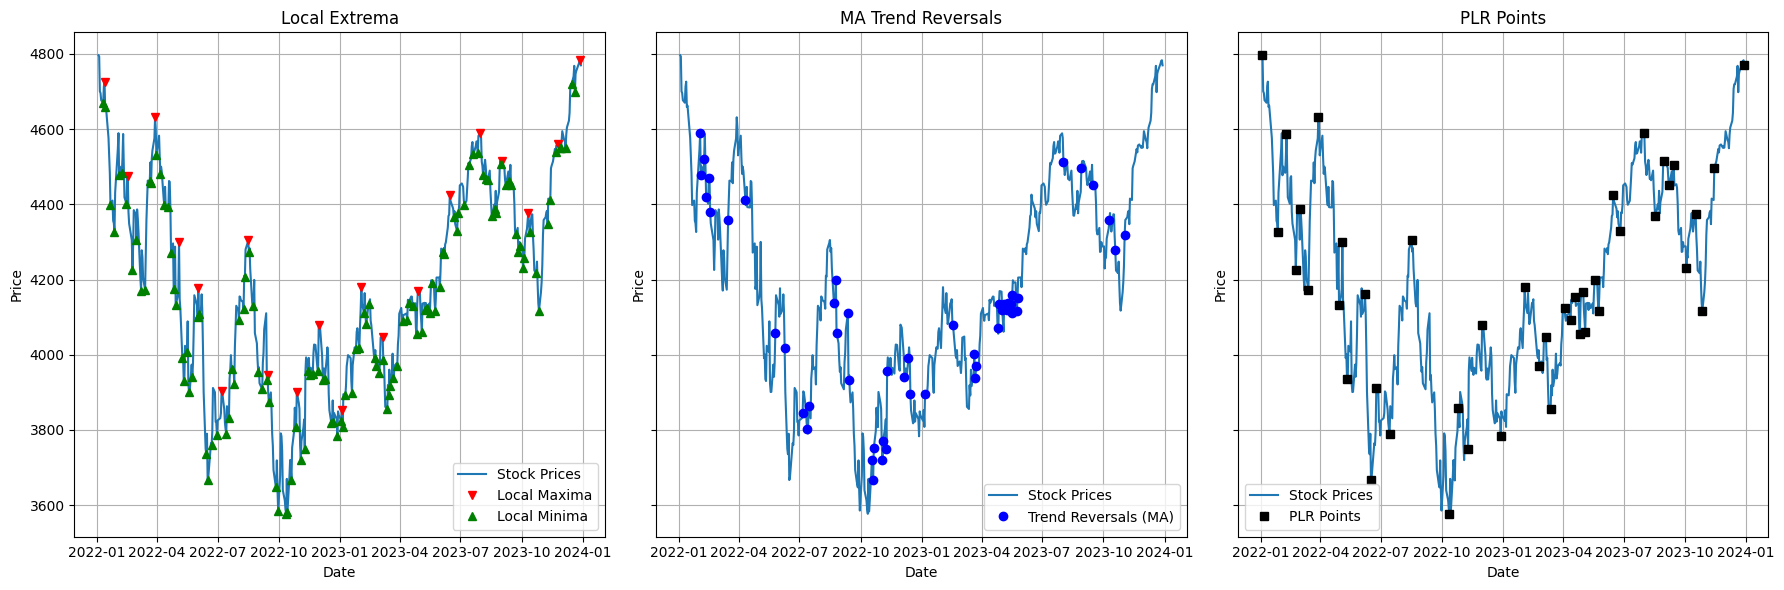

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import yfinance as yf


# 生成虛擬股價資料
np.random.seed(42)
# dates = pd.date_range(start='2023-01-01', periods=200)
prices = yf.download('^GSPC', start='2022-01-01', end='2024-01-01')['Close']
dates = prices.index
# 局部極值
peaks, _ = find_peaks(prices, distance=20)
troughs, _ = find_peaks(-prices)

# MA、股價 連續上漲下跌
def detect_trend_reversals(prices, window=20):
    ma = pd.Series(prices).rolling(window=window).mean()
    trend_reversals = []
    for i in range(window, len(prices) - window):
        if (prices[i] > ma[i] and prices[i-1] < ma[i-1]) or (prices[i] < ma[i] and prices[i-1] > ma[i-1]):
            trend_reversals.append(i)
    return trend_reversals

trend_reversals = detect_trend_reversals(prices)

# PLR (Piecewise Linear Representation)
def plr(prices, epsilon=10.0):
    n = len(prices)
    indices = [0, n - 1]
    
    def max_distance_segment(start, end):
        max_dist = 0
        index = start
        for i in range(start + 1, end):
            p1 = np.array([start, prices[start]])
            p2 = np.array([end, prices[end]])
            p = np.array([i, prices[i]])
            dist = np.abs(np.cross(p2 - p1, p1 - p)) / np.linalg.norm(p2 - p1)
            if dist > max_dist:
                max_dist = dist
                index = i
        return max_dist, index
    
    def iterative_plr(start, end):
        if start >= end:
            return
        max_dist, index = max_distance_segment(start, end)
        if max_dist > epsilon:
            indices.append(index)
            iterative_plr(start, index)
            iterative_plr(index, end)
    
    iterative_plr(0, n - 1)
    indices.sort()
    return indices

plr_indices = plr(prices)


# 繪圖
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# 子圖1：局部極值
axes[0].plot(dates, prices, label='Stock Prices')
axes[0].plot(dates[peaks], prices[peaks], 'rv', label='Local Maxima')
axes[0].plot(dates[troughs], prices[troughs], 'g^', label='Local Minima')
axes[0].legend()
axes[0].set_title('Local Extrema')
axes[0].grid(True)

# 子圖2：MA、股價 連續上漲下跌
axes[1].plot(dates, prices, label='Stock Prices')
axes[1].plot(dates[trend_reversals], prices[trend_reversals], 'bo', label='Trend Reversals (MA)')
axes[1].legend()
axes[1].set_title('MA Trend Reversals')
axes[1].grid(True)

# 子圖3：PLR
axes[2].plot(dates, prices, label='Stock Prices')
axes[2].plot(dates[plr_indices], prices[plr_indices], 'ks', label='PLR Points')
axes[2].legend()
axes[2].set_title('PLR Points')
axes[2].grid(True)

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()


In [1]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import os
import time
import pickle

class ReversePrediction():
    def set_seed(self, seed_value):
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        random.seed(seed_value)
        torch.manual_seed(seed_value)

    def run(self, params):
        self.set_seed(42)
        preprocessor = Preprocessor(params)
        X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset = preprocessor.get_multiple_data()

        start_time = time.time()
        model_wrapper = Model(params=params)
        model, history, y_preds, online_history = \
            model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
        end_time = time.time()
        execution_time = end_time - start_time

        y_preds = torch.tensor(y_preds, dtype=torch.float32)

        y_pred_newest = model.forward(X_newest)
        y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)

        evaluator = Evaluator(params)
        results = evaluator.get_results(y_train, y_val, y_test, y_preds, test_dataset,
                                        test_dates, history, online_history,
                                        show=False)
        results.update({'execution_time': execution_time})
        results.update({'using_data': params})
        
        results_json = json.dumps(results, indent=4)
        with open(params.get('summary_save_path'), 'w') as f:
            f.write(results_json)
            
        return results

2024-06-10 13:54:15.602376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 13:54:15.724687: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 13:54:15.748890: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 13:54:16.202518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
with open('parameters.json', 'r') as f:
    params = json.load(f)

In [3]:
params = {
    "train_indices": [
        "^GSPC",
        "^IXIC",
        "^DJI",
        "^RUA"
    ],
    "test_indices": "^GSPC",
    "start_date": "2001-01-01",
    "stop_date": "2024-01-01",
    "features_params": [
        {
            "type": "Reversals",
            "local_type": "Close",
            "oder_days": 2,
            "ma_days": 5
        },
        {
            "type": "MACD",
            "fastperiod": 5,
            "slowperiod": 10,
            "signalperiod": 9
        },
        {
            "type": "ROC",
            "trend_days": 5
        },
        {
            "type": "Stochastic Oscillator",
            "trend_days": 5
        },
        {
            "type": "CCI",
            "timeperiod": 14
        },
        {
            "type": "RSI",
            "timeperiod": 14
        },
        {
            "type": "MA",
            "timeperiod": 10
        },
        {
            "type": "VMA",
            "timeperiod": 20
        },
        {
            "type": "pctChange"
        },
        {
            "type": "13W Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "5Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "10Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "30Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "Bollinger Bands",
            "timeperiod": 20,
            "nbdevup": 2,
            "nbdevdn": 2
        },
        {
            "type": "ATR",
            "timeperiod": 14
        },
        {
            "type": "OBV"
        },
        {
            "type": "Parabolic SAR",
            "start": 0.02,
            "increment": 0.02,
            "maximum": 0.2
        },
        {
            "type": "MOM",
            "timeperiod": 10
        },
        {
            "type": "Williams %R",
            "lookback_period": 14
        },
        {
            "type": "Chaikin MF",
            "timeperiod": 20
        }
    ],
    "data_cleaning": {
        "clean_type": "MissingData",
        "strategy": "auto"
    },
    "train_split_ratio": 0.7,
    "val_split_ratio": 0.1,
    "target_col": "Reversals",
    "feature_cols": [
        "Open",
        "High",
        "Low",
        "Close",
        "Adj Close",
        "Volume",
        "Reversals",
        "MACD_dif",
        "MACD_dem",
        "MACD_histogram",
        "ROC",
        "StoK",
        "StoD",
        "CCI",
        "RSI",
        "MA",
        "VMA",
        "pctChange",
        "13W Treasury Yield",
        "5Y Treasury Yield",
        "10Y Treasury Yield",
        "30Y Treasury Yield",
        "upperband",
        "middleband",
        "lowerband",
        "ATR",
        "OBV",
        "Parabolic SAR",
        "MOM",
        "Williams %R"
    ],
    "look_back": 64,
    "predict_steps": 10,
    "train_slide_steps": 1,
    "test_slide_steps": 10,
    "model_params": {
        "RNN": {
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2
        },
        "LSTM": {
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2
        },
        "CNN_LSTM": {
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool1d_1_kernel_size": 2,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool1d_2_kernel_size": 2,
            "num_layers": 1,
            "dropout": 0,
            "layer_sizes": [
                256,
                64,
                3
            ],
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "DNN_3layers": {
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512,
            "dropout": 0
        },
        "DNN_5layers": {
            "dropout": 0.2
        },
        "DummyClassifier": {},
        "DNN_FlexibleLayers": {
            "num_layers": 3,
            "layer_sizes": [
                2048,
                512,
                3
            ],
            "dropout": 0,
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "LeNet": {
            "cnn_layers": {
                "kernel_sizes": [
                    5,
                    5,
                    5
                ],
                "paddings": [
                    2,
                    2,
                    2
                ],
                "MaxPool1d_kernel_size": [
                    2,
                    2,
                    2
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    2048,
                    512,
                    3
                ]
            },
            "dropout": 0
        },
        "AlexNet": {
            "cnn_layers": {
                "kernel_sizes": [
                    5,
                    5,
                    5
                ],
                "paddings": [
                    2,
                    2,
                    2
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    2048,
                    512,
                    3
                ],
                "dropout": 0
            }
        },
        "VGG": {
            "cnn_layers": {
                "kernel_sizes": [
                    3,
                    3,
                    3,
                    3
                ],
                "paddings": [
                    1,
                    1,
                    1,
                    1
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    5248,
                    512,
                    3
                ]
            },
            "dropout": 0
        }
    },
    "model_type": "DNN_FlexibleLayers",
    "training_epoch_num": 10000,
    "online_training_epoch_num": 200,
    "online_train_update_interval": 30,
    "learning_rate": 1e-06,
    "online_train_learning_rate": 1e-06,
    "weight_decay": 0,
    "online_train_weight_decay": 0,
    "batch_size": 4096,
    "patience": 50,
    "min_delta": 0,
    "shuffle": False,
    "data_update_mode": "append",
    "trained_model_path": "models/",
    "online_trained_model_path": "models/",
    "reversals_ratio_path": "plots/reversals_ratio.png",
    "confusion_matrix_path": "plots/confusion_matrix.png",
    "training_curve_path": "plots/training_curve.png",
    "online_training_curve_path": "plots/online_training_curve.png",
    "pr_auc_path": "plots/pr_auc.png",
    "roc_auc_path": "plots/roc_auc.png",
    "stock_and_predictions_path": "plots/stock_and_predictions.png",
    "summary_save_path": "reports/summary.json",
    "val_training_curve_path": "plots/val_training_curve.png"
}

In [4]:
import yfinance as yf


In [5]:
rp = ReversePrediction() 
rp.set_seed(42)
# results = rp.run(params)

In [6]:
preprocessor = Preprocessor(params)
X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset = preprocessor.get_multiple_data()

[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape: torch.Size([15831, 64, 30])
Validation set shape: torch.Size([503, 64, 30])
Test set shape: torch.Size([109, 64, 30])


In [7]:
start_time = time.time()
model_wrapper = Model(params=params)
model, history, y_preds, online_history = \
    model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
end_time = time.time()
execution_time = end_time - start_time

y_preds = torch.tensor(y_preds, dtype=torch.float32)


rollback_epoch: 216


100%|██████████| 200/200 [04:45<00:00,  1.43s/it]


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import json
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

class Evaluator:
    def __init__(self, params):
        self.params = params
        pass

    def plot_reversals_ratio_multi(self, y_train_max_indices, y_val_max_indices, y_test_max_indices, y_preds_max_indices, show=True, save_path=None):
        fig, axs = plt.subplots(2, 2, figsize=(12, 6))
        data_sets = [y_train_max_indices, y_val_max_indices, y_test_max_indices, y_preds_max_indices]
        set_labels = ['Train', 'Validation', 'Test', 'Predictions']
        reversals_labels = ['No Reversal', 'Peak', 'Valley']
        reversals_labels_color = {'No Reversal': 'green', 'Peak': 'orange', 'Valley': '#1f77b4'}
        
        for idx, y_data in enumerate(data_sets):
            y_data_label = self._change_labels(y_data, abbreviation=False)
            counts = pd.DataFrame(y_data_label).value_counts().to_dict()
            
            # 將計數字典的鍵處理為字符串
            counts = {k[0]: v for k, v in counts.items()}
            
            # 確保所有標籤都包含，即使計數為0
            count_values = [counts.get(label, 0) for label in reversals_labels]
            count_labels = reversals_labels
            
            count_colors = [reversals_labels_color[label] for label in count_labels]

            row_idx = idx // 2
            col_idx = idx % 2
            
            ax_pie = axs[row_idx, col_idx]
            patches, texts, _ = ax_pie.pie(count_values, labels=count_labels, colors=count_colors, autopct='%1.1f%%', startangle=140)
            ax_pie.axis('equal')
            ax_pie.set_title(f'Reversals Ratio ({set_labels[idx]})')
            
            labels_text = [f'{label}\n({count})' for label, count in zip(count_labels, count_values)]
            ax_pie.legend(patches, labels_text, loc='upper right')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

    def get_confusion_matrix(self, y_test_max_indices, y_preds_max_indices, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test_max_indices.numpy()
        y_preds_np = y_preds_max_indices.numpy()

        # Calculate metrics for each class
        accuracy = accuracy_score(y_test_np, y_preds_np)
        precision = precision_score(y_test_np, y_preds_np, average=None, zero_division=0, labels=[0, 1, 2])
        recall = recall_score(y_test_np, y_preds_np, average=None, zero_division=0, labels=[0, 1, 2])
        f1 = f1_score(y_test_np, y_preds_np, average=None, zero_division=0, labels=[0, 1, 2])

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_np, y_preds_np, labels=[0, 1, 2])

        # Extract True Positives, True Negatives, False Positives, False Negatives for each class
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm.sum() - (FP + FN + TP)

        # Calculate Specificity
        specificity = np.where((TN + FP) != 0, TN / (TN + FP), 0)

        # Calculate False Positive Rate
        fpr = np.where((FP + TN) != 0, FP / (FP + TN), 0)

        # Calculate False Negative Rate
        fnr = np.where((FN + TP) != 0, FN / (FN + TP), 0)

        # Calculate micro-averaging metrics
        micro_precision = precision_score(y_test_np, y_preds_np, average='micro', zero_division=0, labels=[0, 1, 2])
        micro_recall = recall_score(y_test_np, y_preds_np, average='micro', zero_division=0, labels=[0, 1, 2])
        micro_f1 = f1_score(y_test_np, y_preds_np, average='micro', zero_division=0, labels=[0, 1, 2])

        # Calculate macro-averaging metrics
        macro_precision = precision_score(y_test_np, y_preds_np, average='macro', zero_division=0, labels=[0, 1, 2])
        macro_recall = recall_score(y_test_np, y_preds_np, average='macro', zero_division=0, labels=[0, 1, 2])
        macro_f1 = f1_score(y_test_np, y_preds_np, average='macro', zero_division=0, labels=[0, 1, 2])

        # Create DataFrame to store metrics
        # Create DataFrame to store metrics
        unique_labels = np.unique(y_preds_np)
        labels = ['No Reversal', 'Peak', 'Valley']
        present_labels = [labels[i] for i in unique_labels]

        confusion_metrics_info = pd.DataFrame({
            'Class': labels,
            'Accuracy': [accuracy] * len(precision),
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            # 'Specificity': specificity,
            # 'False Positive Rate': fpr,
            # 'False Negative Rate': fnr
        })

        # Add macro-averaging metrics
        macro_avg_info = pd.DataFrame({
            'Class': ['Macro-average'],
            'Accuracy': [accuracy],
            'Precision': [macro_precision],
            'Recall': [macro_recall],
            'F1-Score': [macro_f1],
            # 'Specificity': [specificity],
            # 'False Positive Rate': [fpr],
            # 'False Negative Rate': [fnr]
        })

        # Add micro-averaging metrics
        micro_avg_info = pd.DataFrame({
            'Class': ['Micro-average'],
            'Accuracy': [accuracy],
            'Precision': [micro_precision],
            'Recall': [micro_recall],
            'F1-Score': [micro_f1],
            # 'Specificity': [specificity],
            # 'False Positive Rate': [fpr],
            # 'False Negative Rate': [fnr]
        })

        confusion_metrics_info = pd.concat([confusion_metrics_info, macro_avg_info, micro_avg_info], ignore_index=True)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()
        
        return confusion_metrics_info

    def get_precision_recall_curves(self, y_test, y_preds, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test.numpy()
        y_preds_np = y_preds.numpy()

        # Compute precision and recall for each class
        precision = dict()
        recall = dict()
        for i in range(y_test_np.shape[1]):
            precision[i], recall[i], _ = precision_recall_curve(y_test_np[:, i], y_preds_np[:, i])
        pr_auc = list(range(y_test_np.shape[1]))
        labels = ['No Reversal', 'Peak', 'Valley']
        # Plot Precision-Recall curves for each class
        plt.figure(figsize=(10, 6))
        for i in range(y_test_np.shape[1]):
            pr_auc[i] = -round(np.trapz(precision[i], recall[i]), 4)
            plt.plot(recall[i], precision[i], lw=2, label='{}, auc={:.4f}'.format(labels[i], pr_auc[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='best')
        plt.grid(True)
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()
        return pr_auc
            
    def get_roc_curves(self, y_test, y_preds, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test.numpy()
        y_preds_np = y_preds.numpy()

        # Compute ROC curve and ROC area for each class
        plt.figure(figsize=(10, 6))
        roc_auc = list(range(y_test_np.shape[1]))
        labels = ['No Reversal', 'Peak', 'Valley']
        for i in range(y_test_np.shape[1]):
            fpr, tpr, _ = roc_curve(y_test_np[:, i], y_preds_np[:, i])
            roc_auc[i] = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.4f})'.format(labels[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

        return roc_auc

    def plot_training_curve(self, history, show=True,save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss and validation loss
        ax1.plot(history['loss'], label='Training Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        rollback_epoch = history.get('rollback_epoch')
        if rollback_epoch is not None:
            ax1.axvline(x=rollback_epoch, color='r', linestyle='--', label='Rollback Epoch')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        # Plot accuracy and validation accuracy
        ax2.plot(history['accuracy'], label='Training Accuracy')
        ax2.plot(history['val_accuracy'], label='Validation Accuracy')
        if rollback_epoch is not None:
            ax2.axvline(x=rollback_epoch, color='r', linestyle='--', label='Rollback Epoch')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim([0, 1])
        ax2.grid(True)
        ax2.legend()
        
        fig.suptitle(f'Training Curve, rollback_epoch: {rollback_epoch}')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()
            
    def plot_val_training_curve(self, val_train_history, show=True,save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss and validation loss
        ax1.plot(val_train_history['epoch_loss'][0], label='Val Training Loss')
        ax1.set_title('Val Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        # Plot accuracy and validation accuracy
        ax2.plot(val_train_history['epoch_accuracy'][0], label='Val Training Accuracy')

        ax2.set_title('Val Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim([0, 1])
        ax2.grid(True)
        ax2.legend()

        fig.suptitle(f'Val Training Curve')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

    def plot_online_training_curve(self, online_history, show=True,save_path=None):
        # Create a figure with two subplots
        fig, ax = plt.subplots(2, 2, figsize=(20, 8))
        fig.suptitle('Online Training Curve')
        # Plot loss on the second subplot
        ax[0, 0].plot(online_history['loss'], label='Training Loss')
        ax[0, 0].set_title('Online training loss for the first epoch in each training session')
        ax[0, 0].set_xlabel('Time')
        ax[0, 0].set_ylabel('Loss')
        ax[0, 0].legend()
        ax[0, 0].grid(True)

        # Plot accuracy on the first subplot
        ax[0, 1].plot(online_history['accuracy'], color='tab:red', label='Training Accuracy')
        ax[0, 1].set_title('Online Training Accuracy for the first epoch in each training session')
        ax[0, 1].set_xlabel('Time')
        ax[0, 1].set_ylabel('Accuracy')
        ax[0, 1].set_ylim([0, 1])
        ax[0, 1].legend()
        ax[0, 1].grid(True)

        # ax[1, 0].plot(np.array(online_history['epoch_loss']).flatten(), color='tab:blue', label='Training Loss')
        for epoch in range(0, len(online_history['epoch_loss'])):
            ax[1, 0].plot(range(epoch*len(online_history['epoch_loss'][epoch]), (epoch+1)*len(online_history['epoch_loss'][epoch])), online_history['epoch_loss'][epoch], label='Training Loss' if epoch == 0 else '')
        ax[1, 0].set_title('Online Training Loss for each epoch in each training session')
        ax[1, 0].set_xlabel('epoch')
        ax[1, 0].set_ylabel('Loss')
        ax[1, 0].legend()
        ax[1, 0].grid(True)

        # Plot accuracy on the first subplot
        for epoch in range(0, len(online_history['epoch_accuracy'])):
            ax[1, 1].plot(range(epoch*len(online_history['epoch_accuracy'][epoch]), (epoch+1)*len(online_history['epoch_accuracy'][epoch])), online_history['epoch_accuracy'][epoch], label='Training Accuracy' if epoch == 0 else '')
        ax[1, 1].set_title('Online Training Accuracy for each epoch in each training session')
        ax[1, 1].set_xlabel('epoch')
        ax[1, 1].set_ylabel('Accuracy')
        ax[1, 1].set_ylim([0, 1])
        ax[1, 1].legend()
        ax[1, 1].grid(True)
        # Adjust the layout
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

    def _kbar(self, open, close, high, low, pos, ax):  # for US stocks
        if close > open:
            color = 'green'   # rise
            height = close - open
            bottom = open
        else:
            color = 'red'     # fall
            height = open - close
            bottom = close
        ax.bar(pos, height=height, bottom=bottom, width=0.6, color=color)
        ax.vlines(pos, high, low, color=color)
        
    def _change_labels(self, signal, abbreviation=False):
        signal_np = signal.numpy()
        if abbreviation == True:
            signal_np = np.where(signal_np.astype(str) == '0', "N", signal_np)
            signal_np = np.where(signal_np.astype(str) == '1', "P", signal_np)
            signal_np = np.where(signal_np.astype(str) == '2', "V", signal_np)
        elif abbreviation == False:
            signal_np = np.where(signal_np.astype(str) == '0', "No Reversal", signal_np)
            signal_np = np.where(signal_np.astype(str) == '1', "Peak", signal_np)
            signal_np = np.where(signal_np.astype(str) == '2', "Valley", signal_np)
        return signal_np

    def plot_stock_and_predictions(self, y_test_max_indices, y_preds_max_indices, test_dataset, test_dates, show=True, save_path=None):
        fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

        for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
            self._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
        ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[-1][-1]], label='MA', color='red', linestyle='--')

        peaks_labeled = False
        valleys_labeled = False
        reversal_type = self.params["features_params"][0]["local_type"]
        for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
            if test_dataset['Reversals'].loc[idx] == 1:
                ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
                peaks_labeled = True
            elif test_dataset['Reversals'].loc[idx] == 2:
                ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
                valleys_labeled = True
        ax[0].set_title('Stock Price')
        ax[0].grid(True)
        ax[0].legend()

        
        y_test_label = self._change_labels(y_test_max_indices, abbreviation=True)
        y_preds_label = self._change_labels(y_preds_max_indices, abbreviation=True)
        
        for idx in range(test_dates.shape[0]):
            ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
            ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
            ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
            ax[1].annotate(f"{y_test_label[idx]}", (test_dates[idx][0], 1.7), label='actual')
            ax[1].annotate(f"{y_preds_label[idx]}", (test_dates[idx][0], 1.9), color='red', label='predicted')
        ax[1].set_title('Reversals')
        ax[1].set_ylabel('Class')
        ax[1].set_yticks([0, 1, 2])
        ax[1].grid(True)
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

            
    def get_results(self, y_train, y_val, y_test, y_preds, test_dataset, test_dates, history, online_history, show=True):
        y_train_max_indices = np.argmax(y_train, axis=-1)
        y_val_max_indices = np.argmax(y_val, axis=-1)
        y_test_max_indices = np.argmax(y_test, axis=-1)
        y_preds_max_indices = np.argmax(y_preds, axis=-1)
        
        confusion_metrics_info = self.get_confusion_matrix(y_test_max_indices, y_preds_max_indices, 
                                            show=show, save_path=self.params.get('confusion_matrix_path'))
        self.plot_reversals_ratio_multi(y_train_max_indices, y_val_max_indices, y_test_max_indices, 
                        y_preds_max_indices, show=show, 
                        save_path=self.params.get('reversals_ratio_path'))
        kappa = cohen_kappa_score(y_test_max_indices, y_preds_max_indices)
        mcc = matthews_corrcoef(y_test_max_indices, y_preds_max_indices)
        pr_auc = self.get_precision_recall_curves(y_test, y_preds, show=show, 
                                                  save_path=self.params.get('pr_auc_path'))
        rou_auc = self.get_roc_curves(y_test, y_preds, show=show, save_path=self.params.get('roc_auc_path'))
        self.plot_training_curve(history, show=show, save_path=self.params.get('training_curve_path'))
        self.plot_online_training_curve(online_history, show=show, save_path=self.params.get('online_training_curve_path'))
        self.plot_stock_and_predictions(y_test_max_indices, y_preds_max_indices, test_dataset, test_dates,
                                        show=show, save_path=self.params.get('stock_and_predictions_path'))
        
        results = {
            "confusion metrics": confusion_metrics_info.to_dict(),
            "pr_auc": pr_auc,
            "roc_auc": rou_auc,
            "kappa": kappa,
            "mcc": mcc
            }
        
        return results

/tmp/ipykernel_951490/3092532930.py:82: RuntimeWarning: invalid value encountered in divide
  fnr = np.where((FN + TP) != 0, FN / (FN + TP), 0)


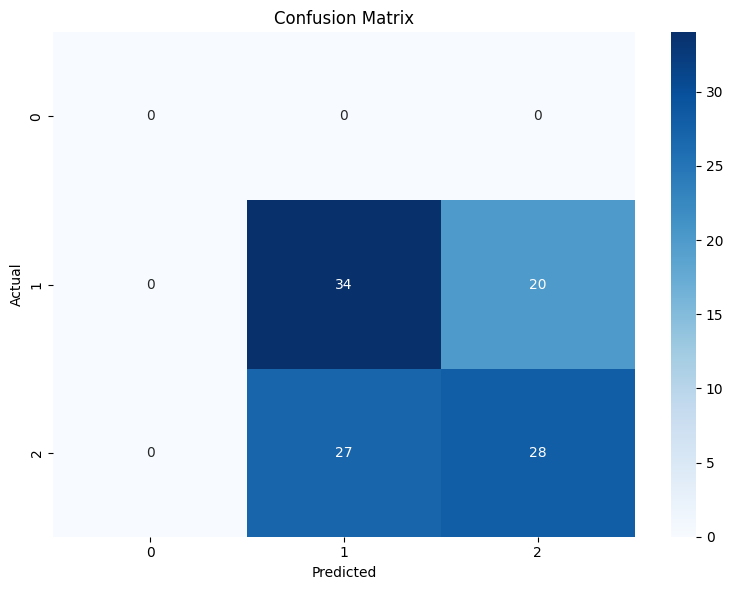

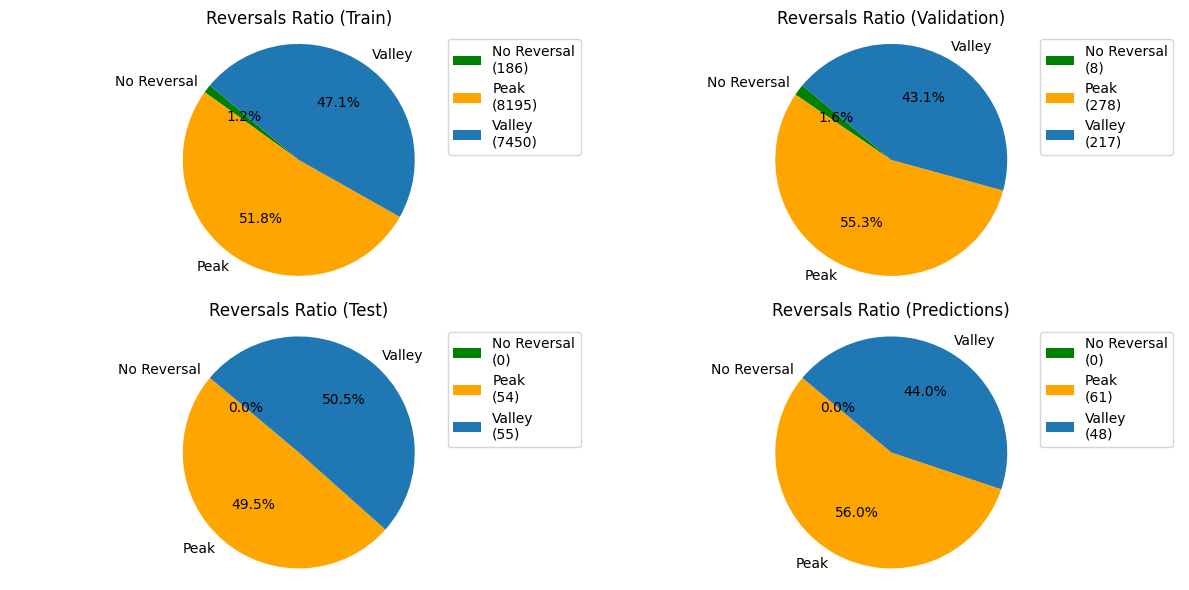

/home/tony/reverse_predict/testenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


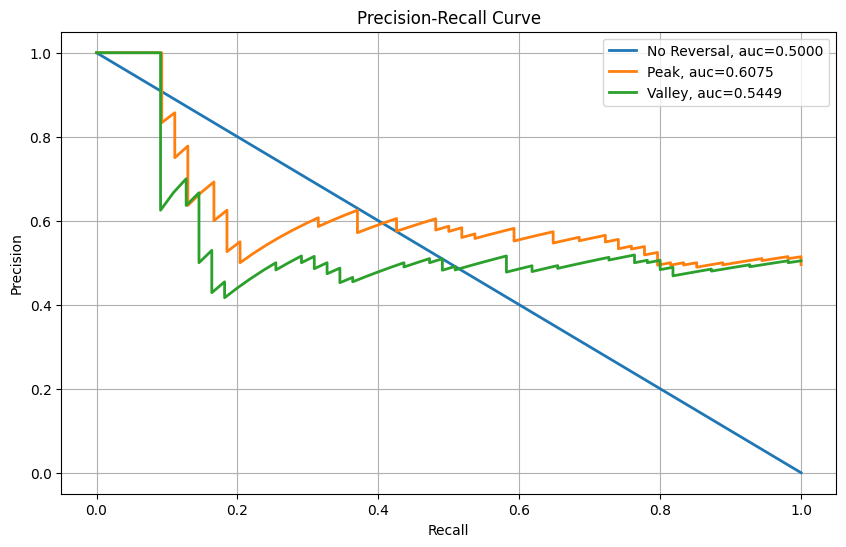

/home/tony/reverse_predict/testenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


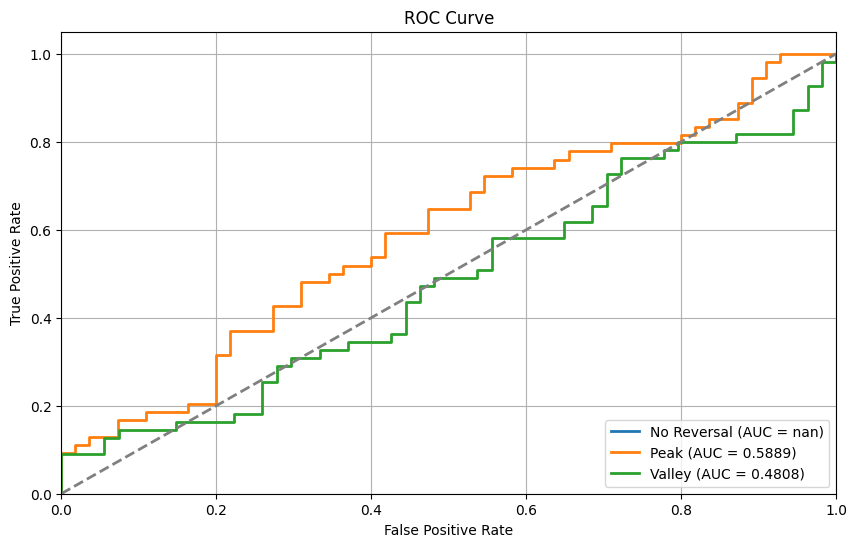

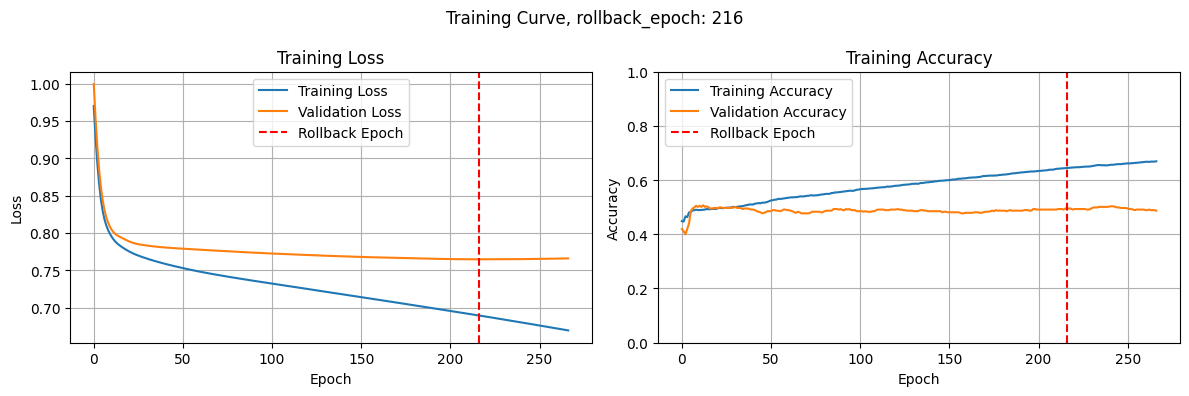

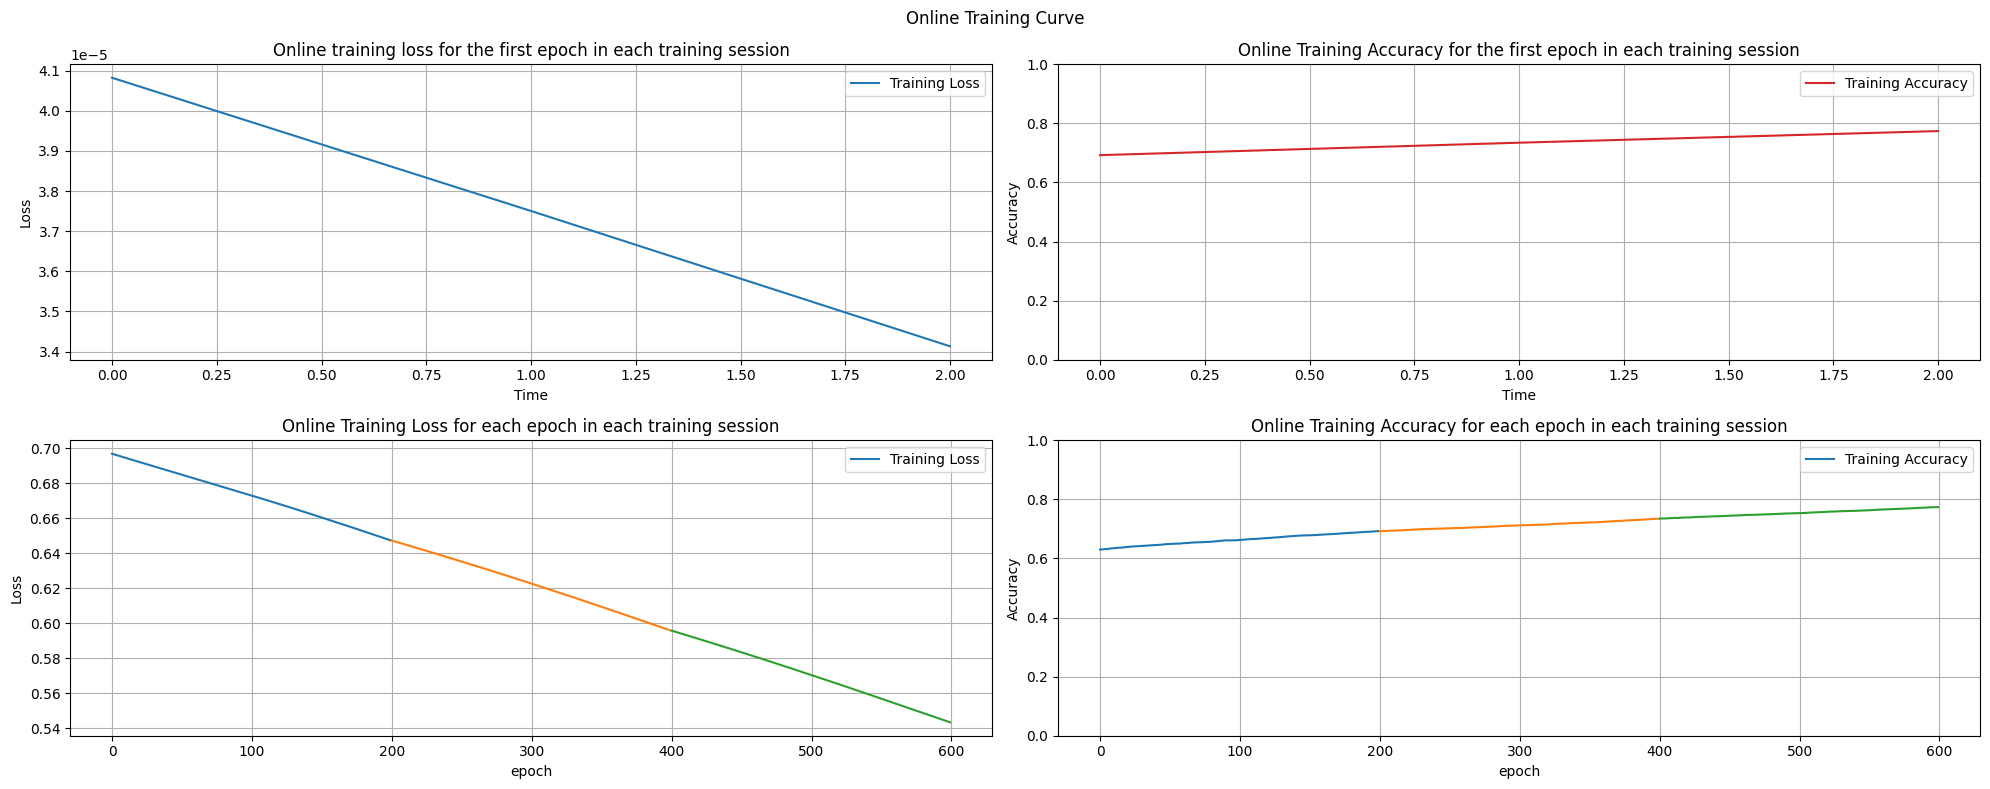

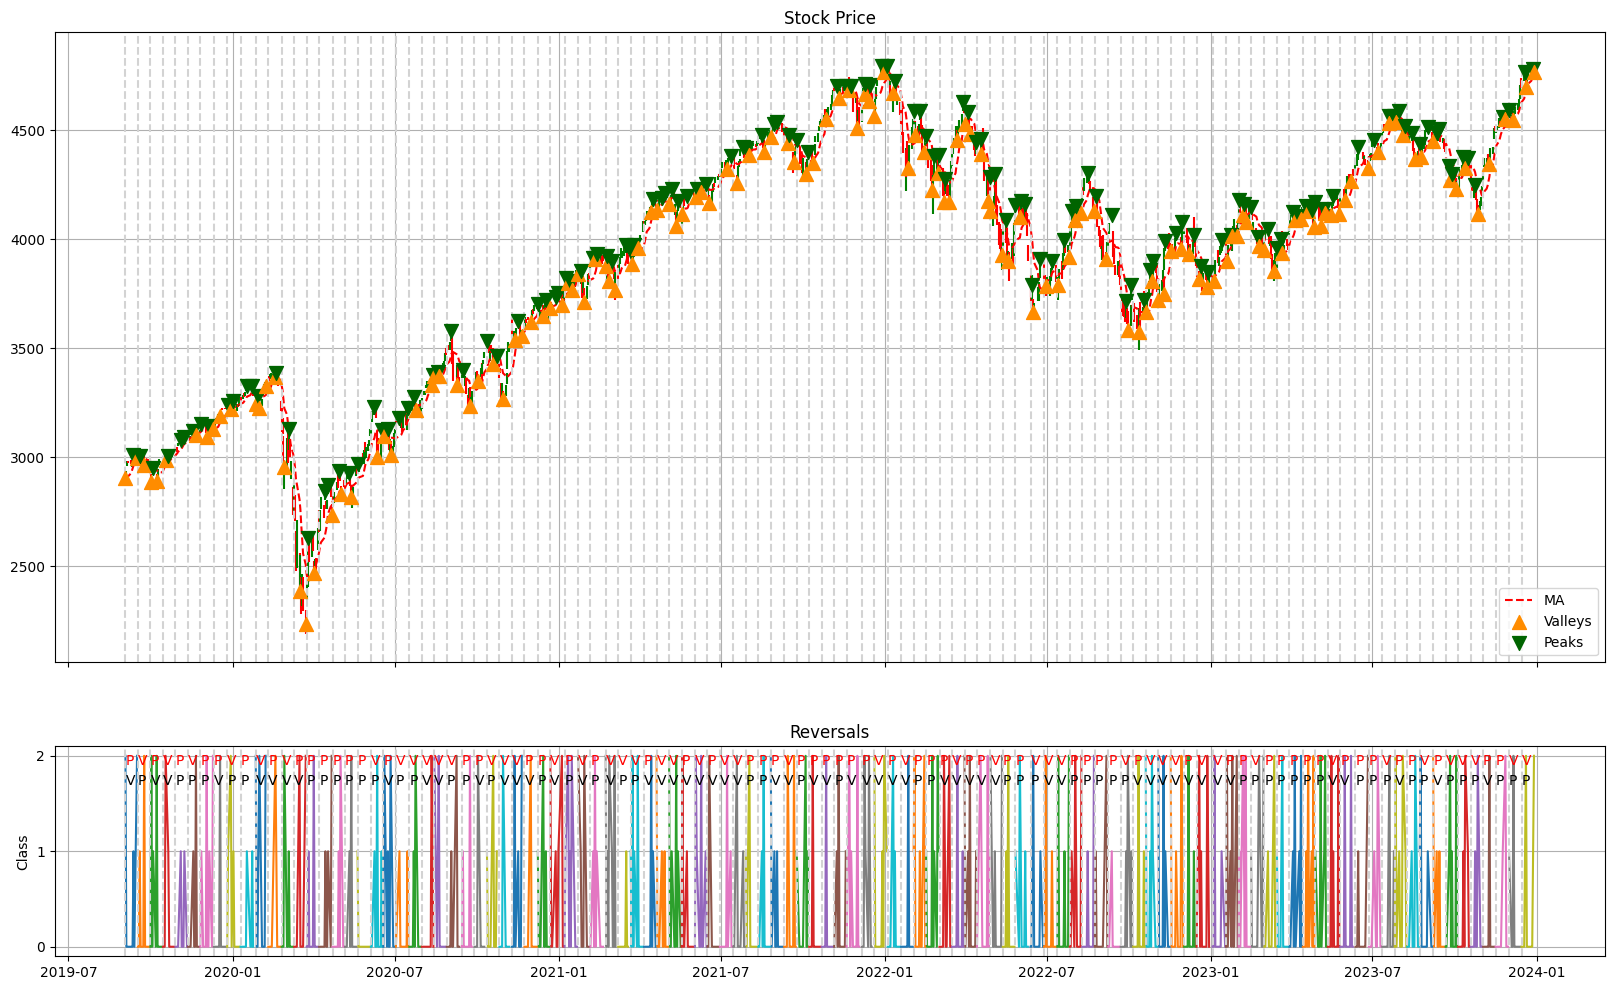

In [21]:
evaluator = Evaluator(params)
results = evaluator.get_results(y_train, y_val, y_test, y_preds, test_dataset,
                                test_dates, history, online_history,
                                show=True)
results.update({'execution_time': execution_time})
results.update({'using_data': params})

results_json = json.dumps(results, indent=4)
with open(params.get('summary_save_path'), 'w') as f:
    f.write(results_json)
            

In [18]:
results

{'confusion metrics': {'Class': {0: 'No Reversal',
   1: 'Peak',
   2: 'Valley',
   3: 'Macro-average',
   4: 'Micro-average'},
  'Accuracy': {0: 0.5688073394495413,
   1: 0.5688073394495413,
   2: 0.5688073394495413,
   3: 0.5688073394495413,
   4: 0.5688073394495413},
  'Precision': {0: 0.0,
   1: 0.5573770491803278,
   2: 0.5833333333333334,
   3: 0.38023679417122036,
   4: 0.5688073394495413},
  'Recall': {0: 0.0,
   1: 0.6296296296296297,
   2: 0.509090909090909,
   3: 0.3795735129068462,
   4: 0.5688073394495413},
  'F1-Score': {0: 0.0,
   1: 0.591304347826087,
   2: 0.5436893203883495,
   3: 0.37833122273814546,
   4: 0.5688073394495413}},
 'pr_auc': [0.5, 0.6075, 0.5449],
 'roc_auc': [nan, 0.5888888888888889, 0.4808080808080808],
 'kappa': 0.1385572557592063,
 'mcc': 0.13971191812393155,
 'execution_time': 1516.6922736167908,
 'using_data': {'train_indices': ['^GSPC', '^IXIC', '^DJI', '^RUA'],
  'test_indices': '^GSPC',
  'start_date': '2001-01-01',
  'stop_date': '2024-01-01',

In [19]:
y_test_max_indices = np.argmax(y_test, axis=-1)
y_preds_max_indices = np.argmax(y_preds, axis=-1)

In [ ]:
def find_sell_entry_point(test_dataset, start_date, end_date, rise_days_limit=3):
    current_check_point = None
    sell_price = None
    consecutive_rise_days = 0

    date_range = test_dataset.loc[start_date: end_date].index

    for idx in date_range:
        current_close = test_dataset['Close'].loc[idx]
        current_low = test_dataset['Low'].loc[idx]
        
        if current_check_point is None:
            current_check_point = current_close
        elif current_close > current_check_point:
            current_check_point = current_close
            consecutive_rise_days += 1
        # else:
        #     current_check_point = current_close
        
        if consecutive_rise_days >= rise_days_limit:
            if current_low < current_check_point:
                sell_price = current_check_point
                # print(f"Sell at {sell_price} on {idx}")
                return sell_price, idx
    return sell_price, None


In [ ]:
def find_buy_entry_point(test_dataset, start_date, end_date, drop_days_limit=3):
    current_check_point = None
    buy_price = None
    consecutive_drop_days = 0

    date_range = test_dataset.loc[start_date: end_date].index

    for idx in date_range:
        current_close = test_dataset['Close'].loc[idx]
        current_high = test_dataset['High'].loc[idx]
        
        if current_check_point is None:
            current_check_point = current_close
        elif current_close < current_check_point:
            current_check_point = current_close
            consecutive_drop_days += 1
        # else:
        #     current_check_point = current_close
        
        if consecutive_drop_days >= drop_days_limit:
            if current_high > current_check_point:
                buy_price = current_check_point
                # print(f"Buy at {buy_price} on {idx}")
                return buy_price, idx
    return buy_price, None
        

In [ ]:
sell_points = []
buy_points = []
for idx in range(0, y_test_max_indices.shape[0]):
    if y_test_max_indices[idx] == 1:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        sell_points.append((sell_price, date))
        if sell_price is not None:
            buy_points.append((test_dataset['Open'].iloc[test_dataset.index.get_loc(date)+3], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else: 
            buy_points.append((None, None))
    if y_test_max_indices[idx] == 2:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        buy_points.append((buy_price, date))
        if buy_price is not None:
            sell_points.append((test_dataset['Open'].iloc[test_dataset.index.get_loc(date)+3], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else:
            sell_points.append((None, None))
    else:
        buy_points.append((None, None))
        sell_points.append((None, None))
buy_amount = 0
sell_amount = 0
buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

In [ ]:
buy_amount, sell_amount, sell_amount - buy_amount

(181696.17944335938, 181547.0400390625, -149.139404296875)

In [ ]:
sell_points = []
buy_points = []
for idx in range(0, y_test_max_indices.shape[0]):
    if y_test_max_indices[idx] == 1:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        sell_points.append((sell_price, date))
        if sell_price is not None:
            buy_points.append((test_dataset['Close'].iloc[test_dataset.index.get_loc(date)+2], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else: 
            buy_points.append((None, None))
    if y_test_max_indices[idx] == 2:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        buy_points.append((buy_price, date))
        if buy_price is not None:
            sell_points.append((test_dataset['Close'].iloc[test_dataset.index.get_loc(date)+2], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else:
            sell_points.append((None, None))
    else:
        buy_points.append((None, None))
        sell_points.append((None, None))
buy_amount = 0
sell_amount = 0
buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

In [ ]:
buy_amount, sell_amount, sell_amount - buy_amount

(181696.83959960938, 181465.4599609375, -231.379638671875)

In [ ]:
sell_points = []
buy_points = []
for idx in range(0, y_test_max_indices.shape[0]):
    if y_test_max_indices[idx] == 1:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx-1][-2], test_dates[idx+1][2])
        else:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        sell_points.append((sell_price, date))
        buy_points.append((None, None))
    if y_test_max_indices[idx] == 2:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        buy_points.append((buy_price, date))
        sell_points.append((None, None))
    else:
        buy_points.append((None, None))
        sell_points.append((None, None))
        
buy_amount = 0
sell_amount = 0
buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

In [ ]:
# sell_points = []
# buy_points = []
# for idx in range(0, y_test_max_indices.shape[0]):
#     if y_test_max_indices[idx] == 1:
#         if idx > 0 and idx < y_test_max_indices.shape[0]-1:
#             sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
#         else:
#             sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
#         sell_points.append((sell_price, date))
#         buy_points.append((None, None))
        
#     if y_test_max_indices[idx] == 2:
#         if idx > 0 and idx < y_test_max_indices.shape[0]-1:
#             buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
#         else:
#             buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
#         buy_points.append((buy_price, date))
#         sell_points.append((None, None))
#     else:
#         buy_points.append((None, None))
#         sell_points.append((None, None))
# buy_amount = 0
# sell_amount = 0
# buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
# sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

In [ ]:
buy_amount, sell_amount, sell_amount - buy_amount

(74591.08935546875, 120114.27026367188, 45523.180908203125)

In [ ]:
signals = np.zeros(len(buy_points))
buy_signals = []
sell_signals = []
for i in range(0, len(buy_points)):
    if buy_points[i][0] is not None:
        signals[i] = 1
        buy_signals.append(buy_points[i][1].date())
    if sell_points[i][0] is not None:
        signals[i] = 2
        sell_signals.append(sell_points[i][1].date())

In [ ]:
# import backtrader as bt
# import pandas as pd
# from datetime import datetime

# # Load data
# data = yf.download('^GSPC', start=datetime(2020, 1, 1), end=datetime(2024, 1, 1))

# class BuySellSignal(bt.SignalStrategy):
#     def __init__(self):
#         pass
    
#     def log(self, txt, dt=None):
#         # Logging function for this strategy
#         dt = dt or self.datas[0].datetime.date(0)
#         print(f'{dt.isoformat()}, {txt}')
     
#     def next(self):
#         if self.data.datetime.date(0) in buy_signals and self.getposition(self.datas[0]).size == 0:
#             self.buy()
#             self.log(f"SAME DAY BUY EXECUTED, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size+1}")
#             self.sell()
#             self.log(f"SAME DAY SELL EXECUTED, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size-1}")
        
#         elif self.data.datetime.date(0) in buy_signals:
#             self.buy()
#             self.log(f"BUY EXECUTED, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size+1}")

#         elif self.data.datetime.date(0) in sell_signals:
#             self.sell()
#             self.log(f"SELL EXECUTED, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size-1}")

# # Initialize cerebro engine
# cerebro = bt.Cerebro()

# # Add strategy
# cerebro.addstrategy(BuySellSignal)

# # Convert data to bt.feeds.PandasData object
# data_feed = bt.feeds.PandasData(dataname=data)

# # Add data to cerebro
# cerebro.adddata(data_feed)

# # Set initial cash
# cerebro.broker.setcash(10000.0)

# # Set commission
# cerebro.broker.setcommission(commission=0.001)

# # Print starting portfolio value
# print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')

# # Run strategy
# cerebro.run()

# # Print final portfolio value
# print(f'Final Portfolio Value: {cerebro.broker.getvalue()}')

# # Plot results
# cerebro.plot()


In [ ]:
import matplotlib.pyplot as plt
evaluator = Evaluator(params)

In [ ]:
reversal_type = evaluator.params["features_params"][0]["local_type"]


(2515.413014160156, 3401.5357939453124)

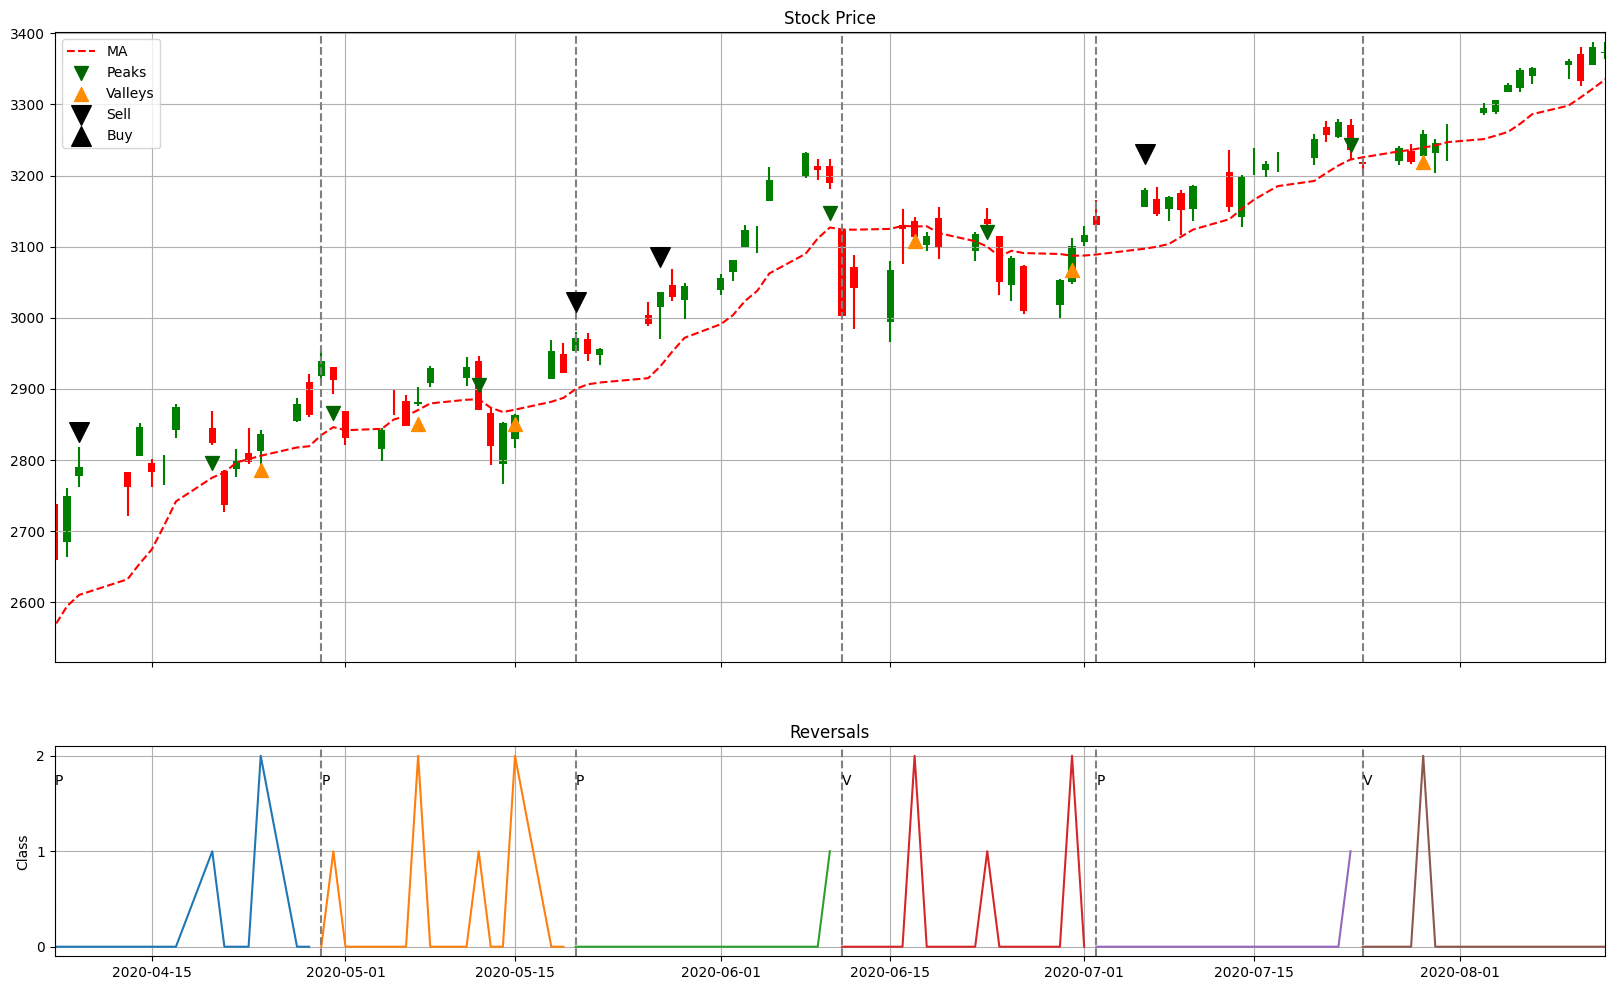

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
    evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[-1][-1]], label='MA', color='red', linestyle='--')

peaks_labeled = False
valleys_labeled = False
reversal_type = evaluator.params["features_params"][0]["local_type"]
for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
    if test_dataset['Reversals'].loc[idx] == 1:
        ax[0].scatter(idx, test_dataset.loc[idx][reversal_type]+20, color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
        peaks_labeled = True
    elif test_dataset['Reversals'].loc[idx] == 2:
        ax[0].scatter(idx, test_dataset.loc[idx][reversal_type]-20, color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
        valleys_labeled = True
    
    
buy_labeled = False
sell_labeled = False 
for info in sell_points:
    if info[0] is not None and info[1] is not None:
        ax[0].scatter(info[1], info[0]+50, color='black', zorder=10, marker='v', s=200, label='Sell' if sell_labeled == False else '')
        sell_labeled = True
        
for info in buy_points:
    if info[0] is not None and info[1] is not None:
        ax[0].scatter(info[1], info[0]-50, color='black', zorder=10, marker='^', s=200, label='Buy' if buy_labeled == False else '')
        buy_labeled = True
        
ax[0].set_title('Stock Price')
ax[0].grid(True)
ax[0].legend()

y_test_label = evaluator._change_labels(y_test_max_indices, abbreviation=True)

for idx in range(test_dates.shape[0]):
    ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
    ax[0].axvline(x=test_dates[idx][0], color='gray', linestyle='--')
    ax[1].axvline(x=test_dates[idx][0], color='gray', linestyle='--')
    ax[1].annotate(f"{y_test_label[idx]}", (test_dates[idx][0], 1.7), label='actual')
ax[1].set_title('Reversals')
ax[1].set_ylabel('Class')
ax[1].set_yticks([0, 1, 2])
ax[1].grid(True)


start = 10
stop = 15
ax[0].set_xlim(test_dates[start][0], test_dates[stop][-1])
ax[0].set_ylim(0.98*test_dataset.loc[test_dates[start][0]: test_dates[stop][-1]][reversal_type].min(), 1.02*test_dataset.loc[test_dates[start][0]: test_dates[stop][-1]][reversal_type].max())

In [ ]:
# for i in range(test_dates.shape[0]):
#     fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

#     for idx in test_dataset.loc[test_dates[i][0]: test_dates[i][-1]].index:
#         evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
#         if test_dataset['Reversals'].loc[idx] == 1:
#             ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
#             peaks_labeled = True
#         elif test_dataset['Reversals'].loc[idx] == 2:
#             ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
#             valleys_labeled = True
            
#     ax[0].plot(test_dataset['MA'].loc[test_dates[i][0]: test_dates[i][-1]], label='MA', color='red', linestyle='--')

#     for idx in range(i, i+1):
#         ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
#         ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
#         ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
        
#     for info in sell_points[i:i+1]:
#         if info[0] is not None and info[1] is not None:
#             ax[0].scatter(info[1], info[0], color='black', label='Sell', zorder=10, marker='v', s=200)
            
#     for info in buy_points[i:i+1]:
#         if info[0] is not None and info[1] is not None:
#             ax[0].scatter(info[1], info[0], color='black', label='Buy', zorder=10, marker='^', s=200)
#     plt.show()

In [ ]:
# for i in range(1, test_dates.shape[0]-1):
#     fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

#     for idx in test_dataset.loc[test_dates[i-1][0]: test_dates[i+1][-1]].index:
#         evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
#         if test_dataset['Reversals'].loc[idx] == 1:
#             ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
#             peaks_labeled = True
#         elif test_dataset['Reversals'].loc[idx] == 2:
#             ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
#             valleys_labeled = True
            
#     ax[0].plot(test_dataset['MA'].loc[test_dates[i-1][0]: test_dates[i+1][-1]], label='MA', color='red', linestyle='--')

#     for idx in range(i, i+1):
#         ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
#         ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
#         ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
        
#         ax[0].axvline(x=test_dates[idx+1][0], color='lightgray', linestyle='--')
#         ax[1].axvline(x=test_dates[idx+1][0], color='lightgray', linestyle='--')
        
#     for info in sell_points[i:i+1]:
#         if info[0] is not None and info[1] is not None:
#             ax[0].scatter(info[1], info[0], color='black', label='Sell', zorder=10, marker='v', s=200)
            
#     for info in buy_points[i:i+1]:
#         if info[0] is not None and info[1] is not None:
#             ax[0].scatter(info[1], info[0], color='blue', label='Buy', zorder=10, marker='^', s=200)
#     plt.show()

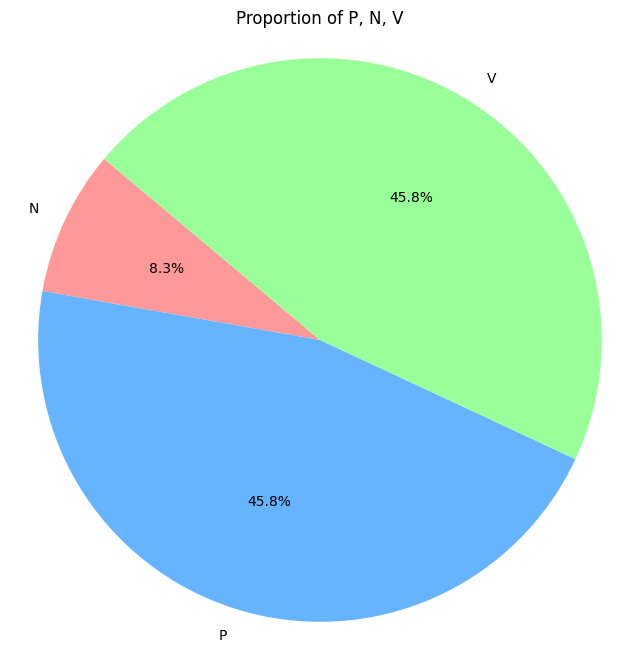

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 給定的陣列
data = y_test_label

# 計算每個字符的出現次數
values, counts = np.unique(data, return_counts=True)

# 計算比例
total_counts = counts.sum()
proportions = counts / total_counts

# 繪製圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(proportions, labels=values, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Proportion of P, N, V')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
